In [1]:
import os
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

def evaluate_and_plot(
    model_path: str,
    hidden_dims: list[int],
    activation: str,
    test_csv: str,
    sample_index: int = 0
):
    """
    model_path: path to your .pth file
    hidden_dims: e.g. [4,4]
    activation: 'relu'|'tanh'|'sigmoid'|'softplus'
    test_csv: path to your test CSV
    sample_index: >=0 for one sample, <0 for all samples
    """
    # --- load & preprocess test data ---
    df = pd.read_csv(test_csv)
    for c in ("F2","F3"):
        if c in df: df.drop(columns=[c], inplace=True)
    y_true = df["Output"].values.astype(float)

    # build Z
    all_in = [f"Input {i}" for i in range(1,19)]
    z_cols = [c for c in all_in if c not in ("Input 10","Input 12")]
    Xz = df[z_cols].copy()

    # encode Inputs 1–8
    cat_map = {
      'Input 1':[1,2], 'Input 2':list(range(1,6)), 'Input 3':list(range(1,6)),
      'Input 4':list(range(1,22)), 'Input 5':list(range(1,6)),
      'Input 6':[1,2,3], 'Input 7':[1,2,3,4], 'Input 8':list(range(1,11))
    }
    for col,cats in cat_map.items():
        if col not in Xz: continue
        if len(cats)==2:
            Xz[col] = Xz[col].map({cats[0]:+1.0, cats[1]:-1.0})
        else:
            Xz[col] = pd.Categorical(Xz[col], categories=cats)
            d = pd.get_dummies(Xz[col], prefix=col)
            for c in cats:
                key = f"{col}_{c}"
                if key not in d: d[key]=0
            Xz = pd.concat([Xz.drop(columns=[col]), d], axis=1)

    # normalize numeric Z
    num_z = [f"Input {i}" for i in range(9,19) if i not in (10,12)]
    pres = [c for c in num_z if c in Xz]
    mu_z, sig_z = Xz[pres].mean(), Xz[pres].std().replace(0,1.0)
    Xz[pres] = (Xz[pres] - mu_z)/sig_z
    Z_np = Xz.to_numpy(dtype=np.float32)

    # Input 10
    x10 = df["Input 10"].values.astype(float)
    mu10, sig10 = x10.mean(), (x10.std() if x10.std()!=0 else 1.0)
    x10_n = (x10 - mu10)/sig10

    # y normalization
    mu_y, sig_y = y_true.mean(), (y_true.std() if y_true.std()!=0 else 1.0)

    # --- rebuild & load model ---
    class MLPm(nn.Module):
        def __init__(self,in_dim,hidden,act):
            super().__init__()
            layers=[]
            for h in hidden:
                layers.append(nn.Linear(in_dim,h))
                if act=='relu':     layers.append(nn.ReLU())
                elif act=='tanh':    layers.append(nn.Tanh())
                elif act=='sigmoid': layers.append(nn.Sigmoid())
                elif act=='softplus':layers.append(nn.Softplus())
                else: raise ValueError(act)
                in_dim=h
            layers.append(nn.Linear(in_dim,1))
            self.net=nn.Sequential(*layers)
        def forward(self,x): return self.net(x)

    class PolyNet(nn.Module):
        def __init__(self,z_dim,hidden,act):
            super().__init__()
            self.A=MLPm(z_dim,hidden,act)
            self.B=MLPm(z_dim,hidden,act)
            self.C=MLPm(z_dim,hidden,act)
            self.sp=nn.Softplus()
        def forward(self,Z,x10):
            a=-self.sp(self.A(Z))
            b=self.B(Z)
            c=self.C(Z)
            return a*(x10**2)+b*x10+c

    device='cuda' if torch.cuda.is_available() else 'cpu'
    z_dim=Z_np.shape[1]
    net=PolyNet(z_dim,hidden_dims,activation).to(device)
    net.load_state_dict(torch.load(model_path,map_location=device))
    net.eval()

    # --- predict ---
    with torch.no_grad():
        Zt=torch.from_numpy(Z_np).to(device)
        x10t=torch.from_numpy(x10_n.reshape(-1,1)).to(device)
        yp_n=net(Zt,x10t).cpu().numpy().flatten()
    y_pred=yp_n*sig_y+mu_y

    # --- error histogram ---
    plt.figure(figsize=(8,6))
    plt.hist(y_pred-y_true,bins=30,edgecolor='k')
    plt.title("Error Histogram")
    plt.xlabel("Predicted – True"); plt.ylabel("Count")
    plt.tight_layout(); plt.show()

    # --- true vs pred scatter ---
    plt.figure(figsize=(8,8))
    plt.scatter(y_true,y_pred,alpha=0.6)
    mn,mx = min(y_true.min(),y_pred.min()), max(y_true.max(),y_pred.max())
    plt.plot([mn,mx],[mn,mx],'k--')
    plt.title("True vs Predicted")
    plt.xlabel("True Output"); plt.ylabel("Predicted Output")
    plt.tight_layout(); plt.show()

    # --- sample sweep helper ---
    def plot_sample(i, ax):
        Zi=Z_np[i:i+1]
        xi, yi=x10[i], y_true[i]
        grid=np.linspace(0,3000,300)
        gn=(grid-mu10)/sig10
        Zr=np.repeat(Zi,300,axis=0)
        with torch.no_grad():
            pn=net(
              torch.from_numpy(Zr).to(device),
              torch.from_numpy(gn.reshape(-1,1)).to(device)
            ).cpu().numpy().flatten()
        p=pn*sig_y+mu_y
        ax.plot(grid,p)
        ax.scatter(xi,yi,color='red',zorder=5)
        ax.set_xlim(0,3000)
        ax.set_ylim(-65000,100000)
        ax.set_xticks([0,3000])
        ax.set_yticks([-65000,100000])
        ax.set_title(f"Sample {i}")
        ax.set_xlabel("Input 10"); ax.set_ylabel("Output")

    # --- plot one or all with 3 per row ---
    n=len(y_true)
    if 0 <= sample_index < n:
        fig, ax = plt.subplots(figsize=(12,8))
        plot_sample(sample_index, ax)
        plt.tight_layout(); plt.show()
    else:
        cols = 3
        rows = int(np.ceil(n/cols))
        fig, axs = plt.subplots(rows, cols, figsize=(cols*6, rows*6))
        axs = axs.flatten()
        for i in range(n):
            plot_sample(i, axs[i])
        # remove any extra axes
        for j in range(n, len(axs)):
            fig.delaxes(axs[j])
        plt.tight_layout(); plt.show()


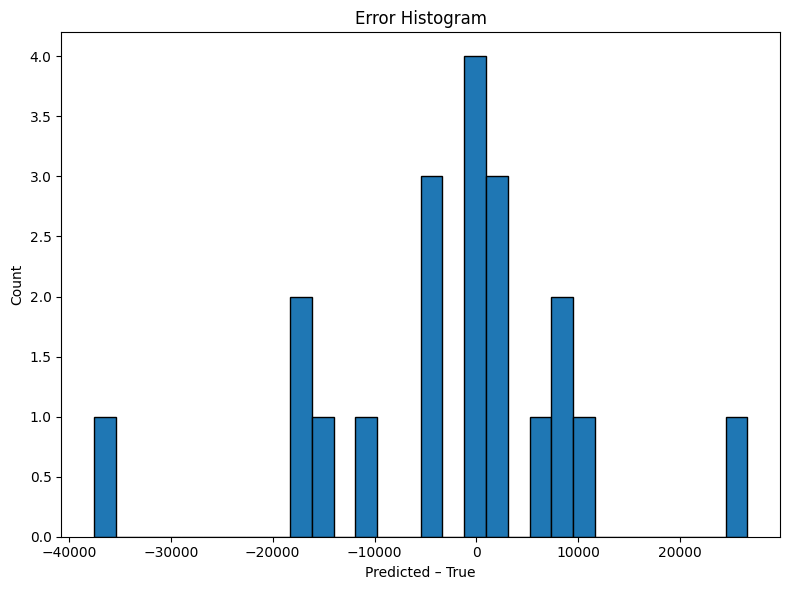

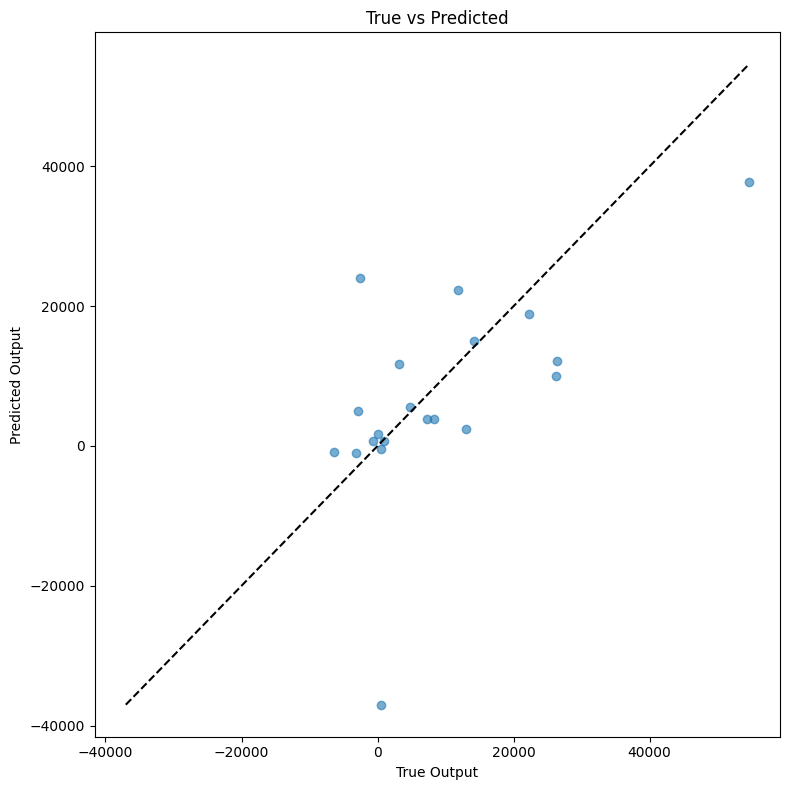

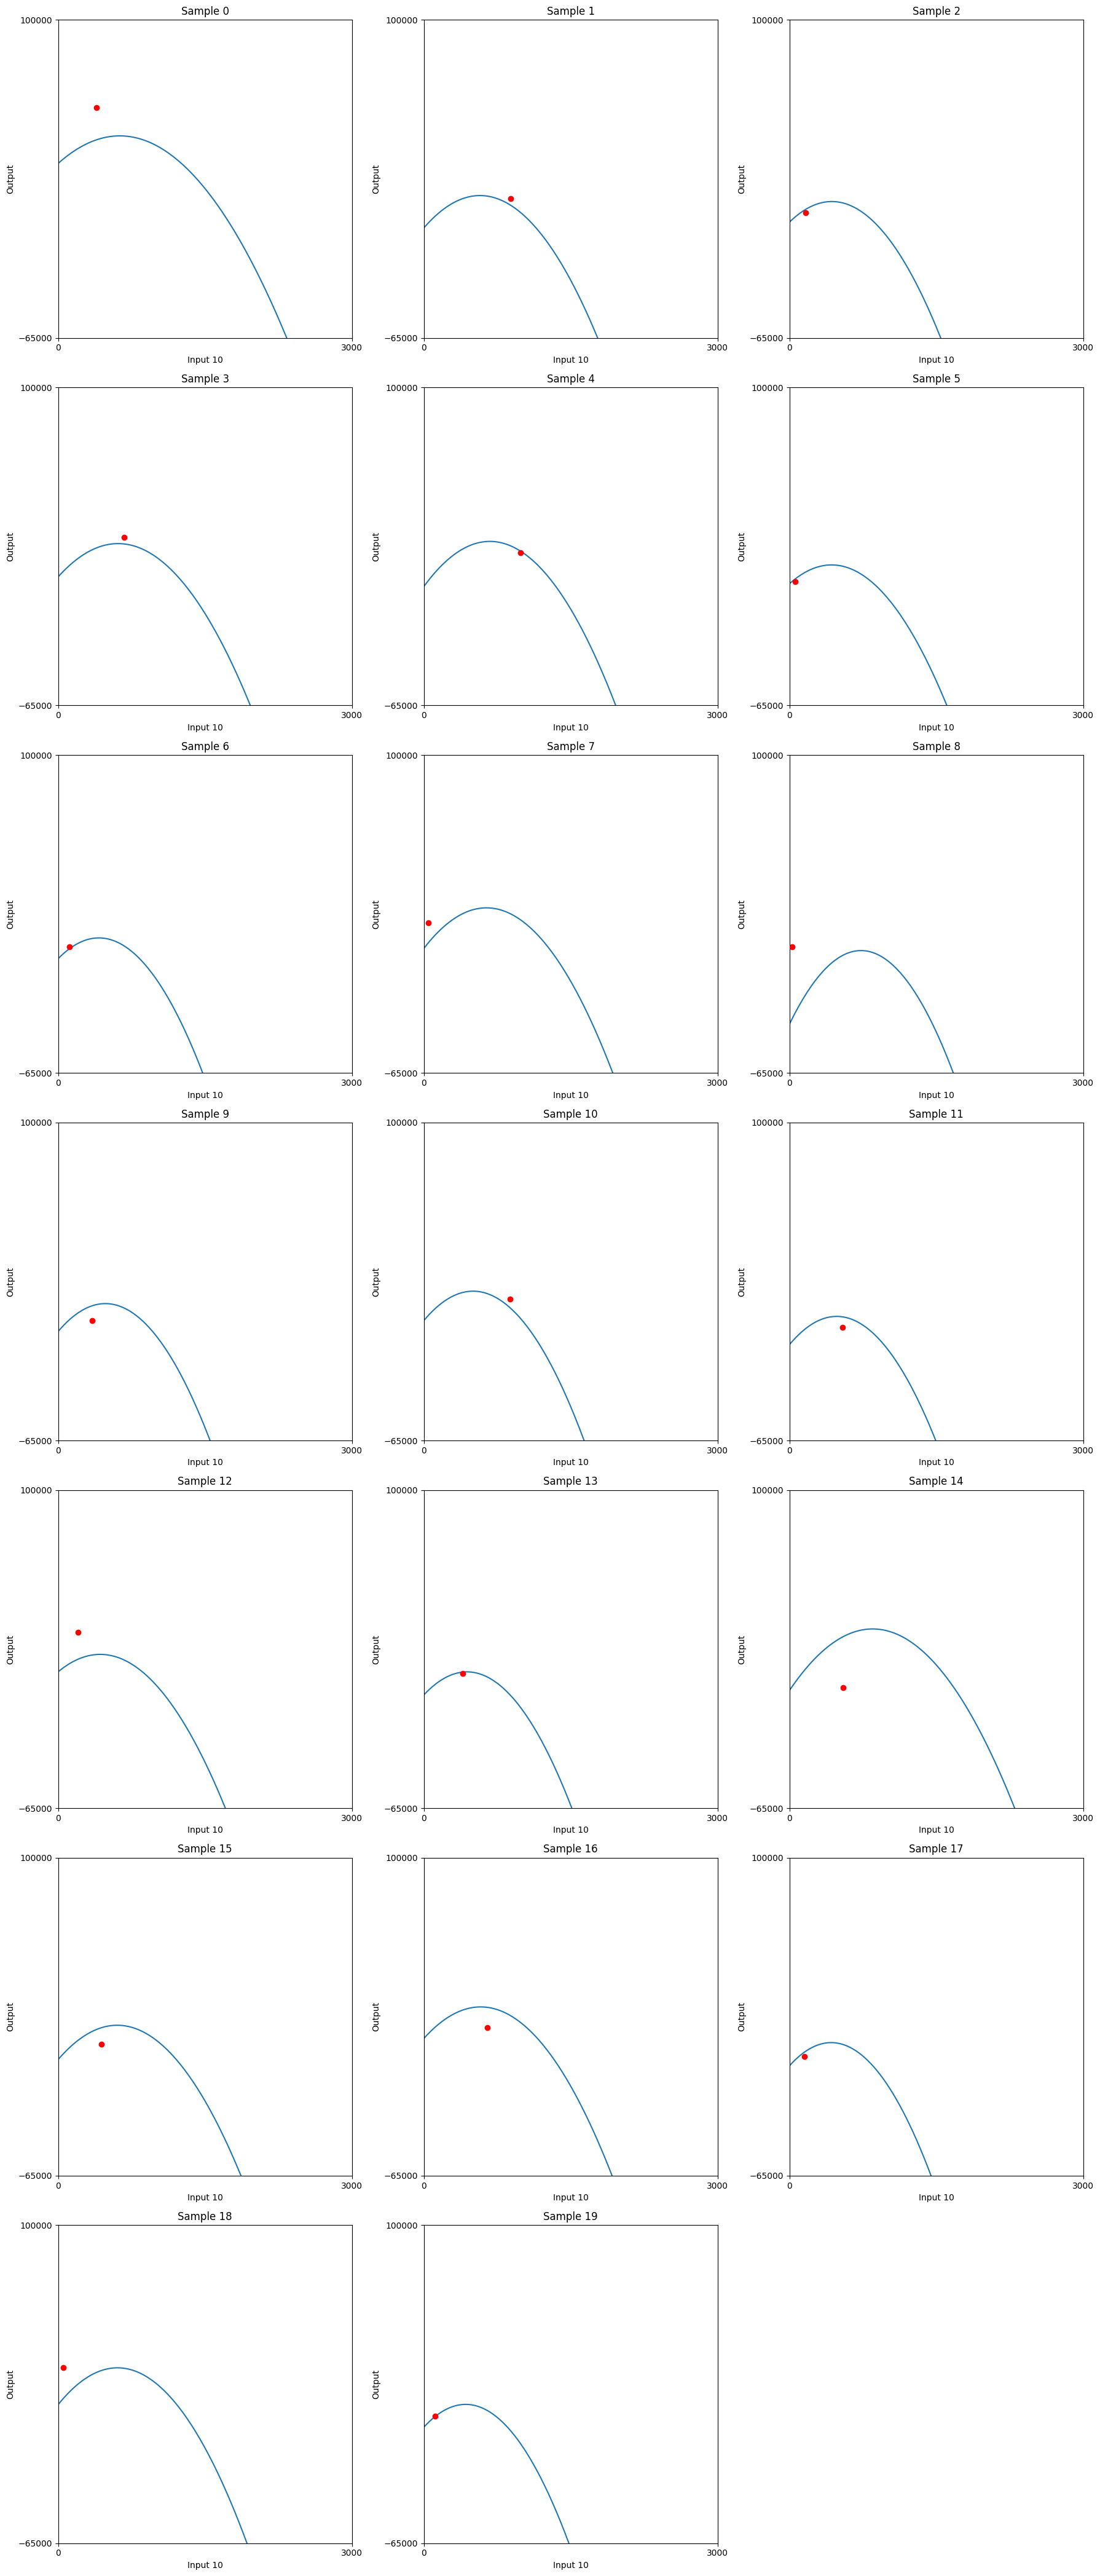

In [2]:
evaluate_and_plot(
    model_path="/home/kamiar/chevron/Acid-neural-net/First Data-V2/7c7c5fc0/7c7c5fc0_fold2.pth",
    hidden_dims=[4,4],
    activation="softplus",
    test_csv="/home/kamiar/chevron/Acid-neural-net/First Data-V2/data/test.csv",
    #test_csv="/home/kamiar/chevron/Acid-neural-net/First Data-V2/data/train_val.csv",
    sample_index=-1
)